# 訪日旅行行動志向の時系列変化分析 ― PCAスコア（PC1〜PC3）による国別志向の推移把握 ―

### 目的とアジェンダ

#### 分析の目的と位置づけ

本分析では、「031_Behavior_PCA.ipynb」において抽出・解釈した3つの主成分（PC1〜PC3）を前提として、各国（市場）の主成分スコアの**時系列推移**を分析する。

ここで用いる主成分スコアは、030で算出・保存した'pca_scores_timeseries.csv'を読み込み、**主成分分析の再実行（再推定）は行わない**。  
本分析の焦点は、スコア水準の絶対値ではなく、各国の**変化方向**および**変化量**に置く。

#### 主要な分析ステップ

1. 主成分スコア分布の全体像（PC1〜PC3の変動規模）
2. 国別 × 主成分の時系列推移（PCごとに確認）
3. 変化方向・変化量の定量化（トレンド指標）
4. 市場ポジションの移動（PC1×PC2、PC1×PC3 等）
5. 結論と示唆（市場タイプの変遷整理）



### 環境構築とデータ準備

In [18]:
# ライブラリのインポート
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# 表示設定
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

DATA_PATH = '../data/'
INPUT_FILENAME = "pca_scores_timeseries.csv"

# データ読込
try:
    # 必須ファイル
    df_ts = pd.read_csv(os.path.join(DATA_PATH, INPUT_FILENAME))
    
except FileNotFoundError as e:
    print(f"エラー: {e.filename} が見つかりません。データファイルを 'data/' フォルダに配置してください。")
    raise

# 基本整形
df_ts["Year"] = df_ts["Year"].astype(int)
df_ts["Country/Area"] = df_ts["Country/Area"].astype(str)

# 欠損チェック
missing = df_ts[["Country/Area", "Year", "PC1", "PC2", "PC3"]].isna().sum()
print("Missing values:\n", missing)

print("Shape:", df_ts.shape)
display(df_ts.head(10))
display(df_ts.describe(include="all"))


Missing values:
 Country/Area    0
Year            0
PC1             0
PC2             0
PC3             0
dtype: int64
Shape: (147, 5)


,Country/Area,Year,PC1,PC2,PC3
0,その他,2015,2.279857,-1.248517,-1.010902
1,その他,2016,2.444064,-0.292951,-0.249035
2,その他,2017,2.517421,-0.332723,-1.453328
3,その他,2018,2.193029,-1.137642,-1.951797
4,その他,2019,2.853669,0.132844,-1.736867
5,その他,2023,1.780785,1.411497,0.777522
6,その他,2024,2.395699,1.222973,1.248975
7,イタリア,2015,2.359315,-1.718710,-1.477559
8,イタリア,2016,3.471911,-0.468533,0.369639
9,イタリア,2017,2.849015,-0.680876,0.827325


,Country/Area,Year,PC1,PC2,PC3
count,147,147.000000,1.470000e+02,147.000000,1.470000e+02
unique,21,NaN,NaN,NaN,NaN
top,その他,NaN,NaN,NaN,NaN
freq,7,NaN,NaN,NaN,NaN
mean,NaN,2018.857143,1.933450e-16,0.000000,2.114711e-17
std,NaN,3.192457,2.797400e+00,1.587613,1.363844e+00
min,NaN,2015.000000,-4.597585e+00,-3.494257,-3.415776e+00
25%,NaN,2016.000000,-2.515673e+00,-1.104186,-1.029177e+00
50%,NaN,2018.000000,-8.542262e-01,-0.071059,1.528639e-01
75%,NaN,2023.000000,2.557285e+00,0.922389,9.570767e-01


### 1. 主成分スコア分布の全体像  ― PC1〜PC3 の変動規模と分析上の位置づけ ―

各主成分（PC1〜PC3）について、全期間・全対象国における主成分スコアの分布を確認する。

具体的には、各主成分スコアの平均、分散、最小値・最大値を把握することで、どの主成分が市場間・時系列で大きく変動しやすい軸であるかを整理する。

#### 解釈の観点
主成分スコアの分散が大きい軸ほど、国別差異や時系列変化が顕在化しやすく、市場構造や行動志向の変化を捉えるうえで中心的な役割を果たす。

一方、分散が相対的に小さい主成分は、補助的な視点として、志向の方向転換や細かな違いを読み取る軸として位置づけられる。

本分析では、PC1 を基調的な行動志向軸、PC2・PC3 を行動様式や行動空間の違いを捉える補助軸として扱う前提をここで確認する。

,count,mean,std,min,25%,50%,75%,max,range
PC1,147.0,1.933450e-16,2.797400,-4.597585,-2.515673,-0.854226,2.557285,4.885388,9.482973
PC2,147.0,0.000000e+00,1.587613,-3.494257,-1.104186,-0.071059,0.922389,3.677002,7.171259
PC3,147.0,2.114711e-17,1.363844,-3.415776,-1.029177,0.152864,0.957077,3.314043,6.729819


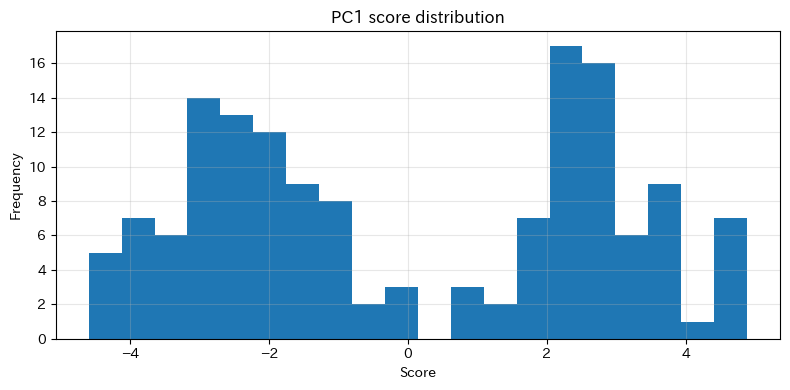

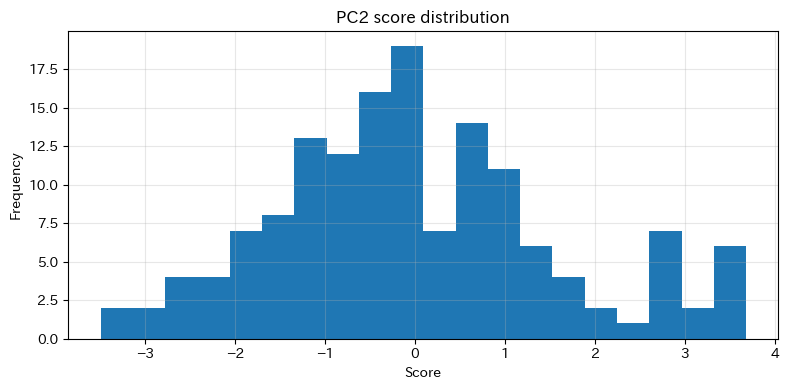

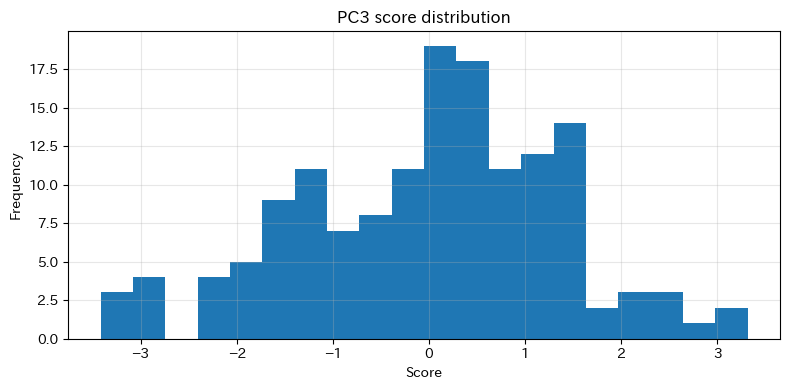

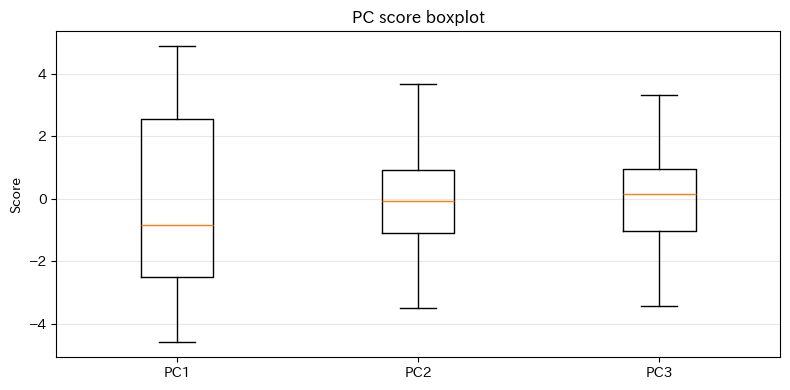

In [ ]:
# ============================================
# 主成分スコア分布の全体像（統計量）
# ============================================
summary = df_ts[["PC1", "PC2", "PC3"]].describe().T
summary["range"] = summary["max"] - summary["min"]
display(summary)
# ============================================
# 分布可視化（ヒストグラム）
# ============================================
pcs = ["PC1", "PC2", "PC3"]

for pc in pcs:
    plt.figure(figsize=(8, 4))
    plt.hist(df_ts[pc].dropna(), bins=20)
    plt.title(f"{pc} score distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# ============================================
# 分布可視化（箱ひげ）
# ============================================
pcs = ["PC1", "PC2", "PC3"]

plt.figure(figsize=(8, 4))
plt.boxplot([df_ts[pc].dropna() for pc in pcs], tick_labels=pcs)
plt.title("PC score boxplot")
plt.ylabel("Score")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


いずれの主成分についても平均値はほぼ 0 に近く、主成分スコアが標準化された相対指標として適切に算出されていることが確認できる。

##### ■PC1（日本文化・体験志向の強さ）

PC1 の標準偏差は **約 2.79** と最も大きく、スコアのレンジも **約 9.48（-4.60〜4.89）** と広い。

ヒストグラムおよび箱ひげ図からは、正負の両方向に広く分布しており、市場間・時系列の差異が大きい軸であることが明確に読み取れる。

このことから PC1 は、**訪日旅行者の行動特性を規定する最も基調的な軸**であり、国ごとの行動志向の違いや、その変化を捉えるうえで中心的な役割を果たす主成分であると位置づけられる。

##### ■PC2（アクティブ志向 vs 和の寛ぎ・滞在志向）

PC2 の標準偏差は **約1.59** と PC1 に比べて小さいものの、スコアのレンジは **約 7.17（-3.49〜3.68）** と一定の広がりを持つ。

分布は 0 付近を中心に比較的集中しており、極端な値をとる市場は限定的である。

これは PC2 が、市場全体を大きく二分する基調軸というよりも、**旅行スタイルや行動様式の違いを表す性格の強い軸**であることを示唆している。

したがって PC2 は、PC1 で捉えられる基調的な行動志向の上で、「どのような形で旅行を楽しんでいるか」を補足的に説明する主成分として位置づけられる。

##### ■PC3（自然・地方志向 vs 都市型娯楽志向）

PC3 の標準偏差は **約1.36** と 3 主成分の中で最も小さく、レンジも **約 6.73（-3.42〜3.31）** と相対的に限定的である。

分布は PC2 と同様に 0 付近に集中しつつ、正負方向に一定の広がりを持つ形となっている。

このことから PC3 は、市場全体の大きな差異を説明する主軸ではなく、**行動の舞台が「都市型」か「自然・地方型」かという空間的志向の違い**を捉える補助的な軸と解釈できる。

##### ■分析上の位置づけ

以上を踏まえると、3 つの主成分は以下のように整理できる。

- **PC1**：市場間・時系列で最も変動が大きい基調的行動志向軸  
- **PC2**：旅行スタイル（行動様式）の違いを捉える補助軸  
- **PC3**：行動空間（都市型／自然・地方型）の違いを捉える補助軸  

この分布特性により、030_PCA_Structure_Analysis.ipynb における主成分の解釈・命名と整合的であり、本 Notebook において **PC1 を中心軸としつつ、PC2・PC3 を組み合わせて市場の動態を読む**という分析方針を採用することが適切であると考えられる。

### 2. 国別 × 主成分の時系列推移 ― 行動志向はどのように変化してきたか ―

各主成分（PC1〜PC3）ごとに、国別の主成分スコアが年次でどのように推移しているかを確認する。

分析は主成分ごとに分けて行い、同一の行動軸上で各国市場がどの方向へ変化しているのかを把握する。

#### 解釈の観点
ここで注目するのは、主成分スコアの絶対水準ではなく、**変化の方向（上昇・低下）および変化の大きさ**である。

同一の国であっても、時期によって訪日旅行者の行動志向が変化している可能性があり、それは主成分スコアの推移として明確に観測される。

本節の分析により、「どの国が来ているか」ではなく「どのような行動特性を持つ旅行者が来ているか」という視点から、市場の動態を把握する。

,n_years
Country/Area,
その他,7
イタリア,7
インド,7
インドネシア,7
オーストラリア,7
カナダ,7
シンガポール,7
スペイン,7
タイ,7


Countries: 21  / Min years: 7  / Max years: 7
Selected countries (by latest extremes): 20


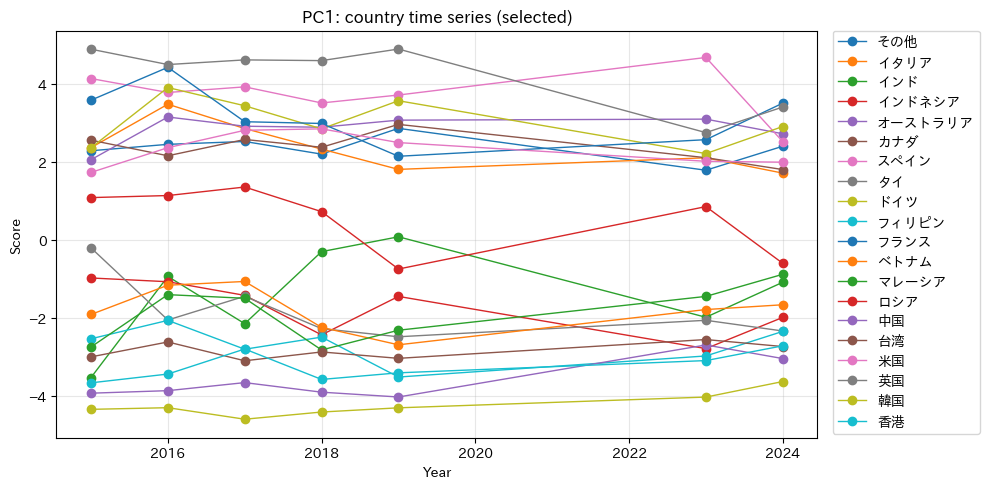

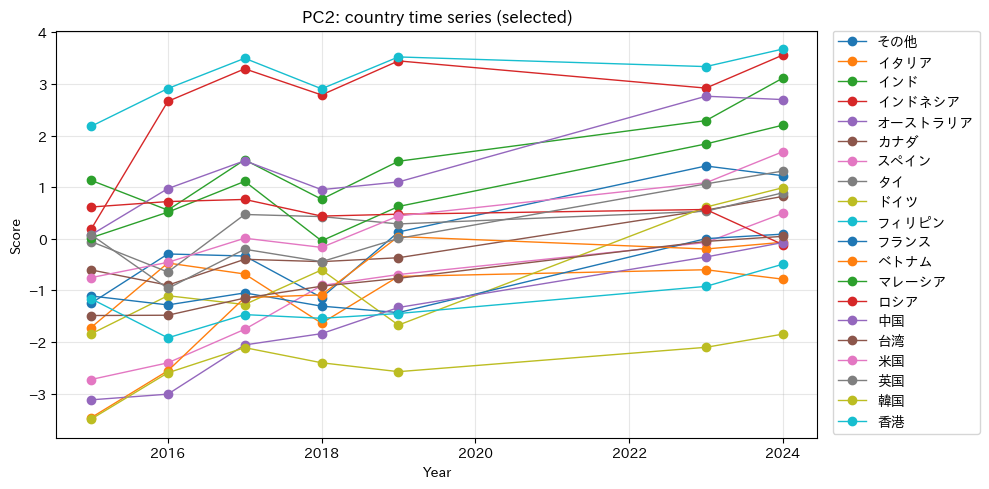

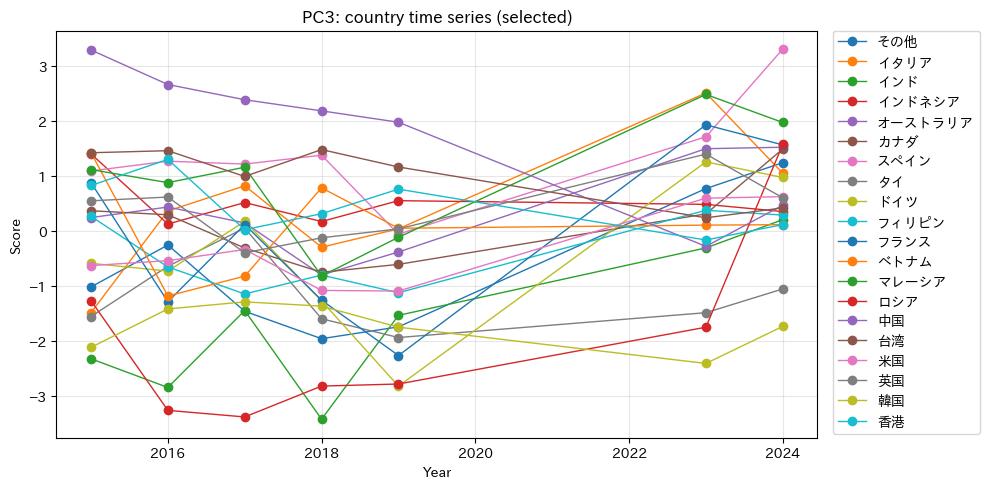

In [ ]:
# ============================================
# カバレッジ確認（国ごとの観測年数）
# ============================================
coverage = df_ts.groupby("Country/Area")["Year"].nunique().sort_values(ascending=False)
display(coverage.to_frame("n_years").head(20))
print("Countries:", coverage.shape[0], " / Min years:", coverage.min(), " / Max years:", coverage.max())
# ============================================
# 代表国選定（最新年の極端値）
# ============================================
latest_year = df_ts["Year"].max()
df_latest = df_ts[df_ts["Year"] == latest_year].copy()

# 各PCで最新年スコアの上位/下位を抽出
TOP_K = 6  # 可視化に耐える程度
selected_countries = set()

for pc in ["PC1", "PC2", "PC3"]:
    top = df_latest.nlargest(TOP_K, pc)["Country/Area"].tolist()
    bottom = df_latest.nsmallest(TOP_K, pc)["Country/Area"].tolist()
    selected_countries.update(top + bottom)

selected_countries = sorted(selected_countries)
print("Selected countries (by latest extremes):", len(selected_countries))
selected_countries[:20], "..."
# ============================================
# 国別×年の推移（PCごと、代表国のみ）
# ============================================
df_sel = df_ts[df_ts["Country/Area"].isin(selected_countries)].copy()

for pc in ["PC1", "PC2", "PC3"]:
    plt.figure(figsize=(10, 5))
    for c in selected_countries:
        tmp = df_sel[df_sel["Country/Area"] == c]
        if tmp.empty:
            continue
        plt.plot(tmp["Year"], tmp[pc], marker="o", linewidth=1, label=c)

    plt.title(f"{pc}: country time series (selected)")
    plt.xlabel("Year")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)

    # 凡例が多い場合は外に出す（Notebookで見やすく）
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()


##### ■PC1（日本文化・体験志向の強さ）の推移

PC1 の時系列推移を見ると、国ごとに水準および変動幅に明確な違いが確認できる。  

一部の国では、期間を通じて高い正のスコアを維持しており、日本文化・体験への関心が一貫して強い市場であることが示唆される。  
一方で、負の領域に位置する国も多く、これらの市場では相対的に文化・体験志向が弱い、あるいは他の行動要素が優先されている可能性がある。

また、複数の国においてスコアの上下動が見られることから、PC1 は単なる国別の固定的な特性ではなく、**同一国であっても訪日旅行者の関心の向きが時期によって変化している**可能性を示している。

この結果は、PC1 が本分析における基調的な行動志向軸であり、国別・時系列の双方で差異が最も顕在化しやすい主成分であることを示唆している。

##### ■PC2（アクティブ志向 vs 和の寛ぎ・滞在志向）の推移

PC2 の推移を見ると、多くの国でスコアが 0 付近を中心に推移しており、PC1 と比べると変動幅は相対的に小さい。
しかしながら、いくつかの国では時間の経過とともに正の方向（アクティブ志向側）または負の方向（滞在・寛ぎ志向側）へ緩やかなシフトが確認できる。

これは PC2 が、**訪日旅行者の「旅行の仕方」や行動様式の違いを表す軸**として機能しており、大きな断絶ではないものの、市場ごとに行動スタイルの変化が徐々に進行していることを示唆している。

##### ■PC3（自然・地方志向 vs 都市型娯楽志向）の推移

PC3 の時系列推移では、PC2 と同程度の変動規模の中で、国ごとに異なる方向性の変化が観測される。
一部の国では、負の領域（都市型志向側）から正の領域（自然・地方志向側）へ、あるいはその逆方向へとスコアが推移しており、**訪日旅行の主な行動空間が変化している可能性**が示唆される。

特に、時系列の後半において複数の国でスコアの方向転換が見られる点は、訪日旅行の回復過程や旅行行動の再編が、都市集中型と地方・自然志向型の間で分化して進んでいることを示す重要な示唆といえる。

##### ■時系列推移から得られる示唆

以上の時系列分析から、以下の点が示唆される。

- 訪日旅行者の行動志向は、国ごとに固定されたものではなく、**時間とともに変化する動的な特性**である。
- PC1 は、国別・時系列の差異が最も大きく、市場の質的変化を捉える中心的な軸である。
- PC2 および PC3 は、行動スタイルや行動空間の違いといった側面から、市場の変化を補完的に捉える主成分として有効である。

### 3. 変化方向・変化量の定量化 ― 主成分スコアのトレンド指標による市場整理 ―

各国・各主成分について、主成分スコアの年次変化をトレンドとして定量化する。

具体的には、年を説明変数、主成分スコアを被説明変数とした単回帰を行い、その傾き（スロープ）を用いて、各市場における行動志向の変化方向および変化量を整理する。

#### 解釈の観点
トレンドの正負は、行動志向が強まっているか弱まっているかを示し、傾きの絶対値は、その変化の大きさを表す。

この指標を用いることで、一時的な上下ではなく、**中期的にどの方向へ市場が動いているか**を把握することが可能となる。
また、複数の主成分におけるトレンドを組み合わせることで、各国市場の行動特性の変化を、より立体的に捉える。

,Country/Area,pc,slope,n_years
0,その他,PC1,-0.031412,7
1,その他,PC2,0.273818,7
2,その他,PC3,0.259382,7
3,イタリア,PC1,-0.120910,7
4,イタリア,PC2,0.056924,7
5,イタリア,PC3,0.271175,7
6,インド,PC1,0.095126,7
7,インド,PC2,0.229383,7
8,インド,PC3,0.314346,7
9,インドネシア,PC1,-0.146839,7


Countries used (MIN_YEARS>=3): 21

=== PC1 | slope top (+) ===


,Country/Area,slope,n_years
45,中国,0.126363,7
39,マレーシア,0.125929,7
6,インド,0.095126,7
57,韓国,0.075930,7
60,香港,0.069838,7
18,シンガポール,0.044556,7
12,オーストラリア,0.034378,7
48,台湾,0.030793,7
36,ベトナム,-0.024535,7
30,フィリピン,-0.026461,7


=== PC1 | slope bottom (-) ===


,Country/Area,slope,n_years
54,英国,-0.205874,7
9,インドネシア,-0.146839,7
42,ロシア,-0.144262,7
24,タイ,-0.135604,7
3,イタリア,-0.120910,7
33,フランス,-0.079792,7
27,ドイツ,-0.063035,7
15,カナダ,-0.062253,7
21,スペイン,-0.059107,7
0,その他,-0.031412,7



=== PC2 | slope top (+) ===


,Country/Area,slope,n_years
46,中国,0.338776,7
22,スペイン,0.332300,7
37,ベトナム,0.318487,7
28,ドイツ,0.289827,7
1,その他,0.273818,7
13,オーストラリア,0.264991,7
52,米国,0.247897,7
7,インド,0.229383,7
40,マレーシア,0.217926,7
19,シンガポール,0.209703,7


=== PC2 | slope bottom (-) ===


,Country/Area,slope,n_years
43,ロシア,-0.061889,7
4,イタリア,0.056924,7
61,香港,0.105123,7
31,フィリピン,0.106214,7
25,タイ,0.107736,7
58,韓国,0.117115,7
34,フランス,0.159044,7
16,カナダ,0.176090,7
49,台湾,0.180737,7
10,インドネシア,0.198671,7



=== PC3 | slope top (+) ===


,Country/Area,slope,n_years
44,ロシア,0.329472,7
8,インド,0.314346,7
5,イタリア,0.271175,7
2,その他,0.259382,7
35,フランス,0.238045,7
29,ドイツ,0.210577,7
23,スペイン,0.180921,7
14,オーストラリア,0.172210,7
41,マレーシア,0.171398,7
53,米国,0.155875,7


=== PC3 | slope bottom (-) ===


,Country/Area,slope,n_years
47,中国,-0.353675,7
50,台湾,-0.133355,7
62,香港,-0.101503,7
59,韓国,-0.047590,7
11,インドネシア,-0.041980,7
26,タイ,-0.038797,7
38,ベトナム,-0.003210,7
20,シンガポール,0.024337,7
56,英国,0.082780,7
32,フィリピン,0.092329,7


trend_type,Down,Flat,Up
pc,,,
PC1,5,13,3
PC2,0,2,19
PC3,1,11,9


,Country/Area,pc,slope,n_years,trend_type,threshold
1,イタリア,PC1,-0.120910,7,Down,0.092855
8,タイ,PC1,-0.135604,7,Down,0.092855
14,ロシア,PC1,-0.144262,7,Down,0.092855
3,インドネシア,PC1,-0.146839,7,Down,0.092855
18,英国,PC1,-0.205874,7,Down,0.092855
19,韓国,PC1,0.075930,7,Flat,0.092855
20,香港,PC1,0.069838,7,Flat,0.092855
6,シンガポール,PC1,0.044556,7,Flat,0.092855
4,オーストラリア,PC1,0.034378,7,Flat,0.092855
16,台湾,PC1,0.030793,7,Flat,0.092855


Selected countries (by |slope| top): 14


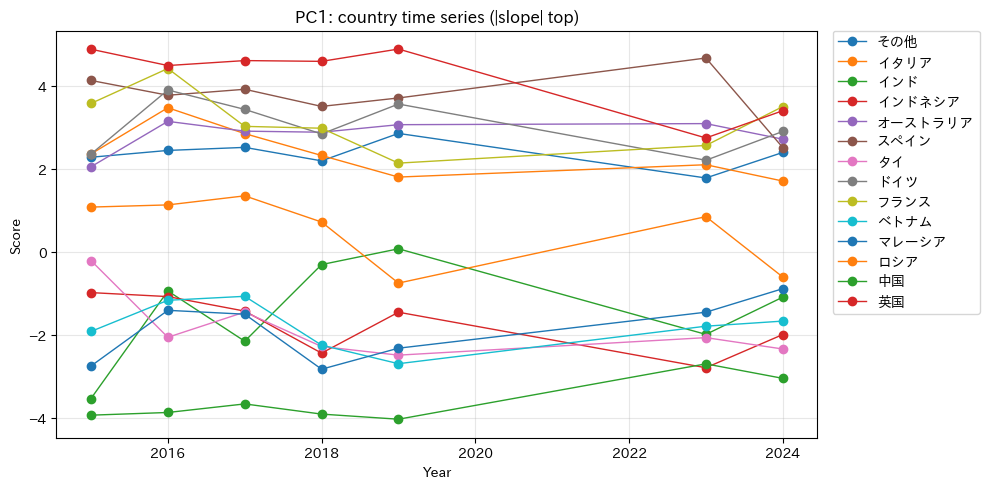

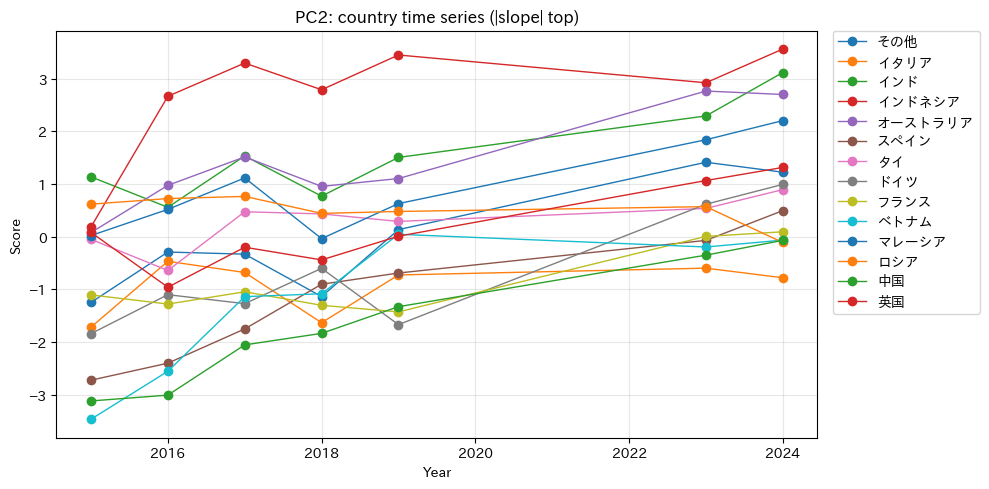

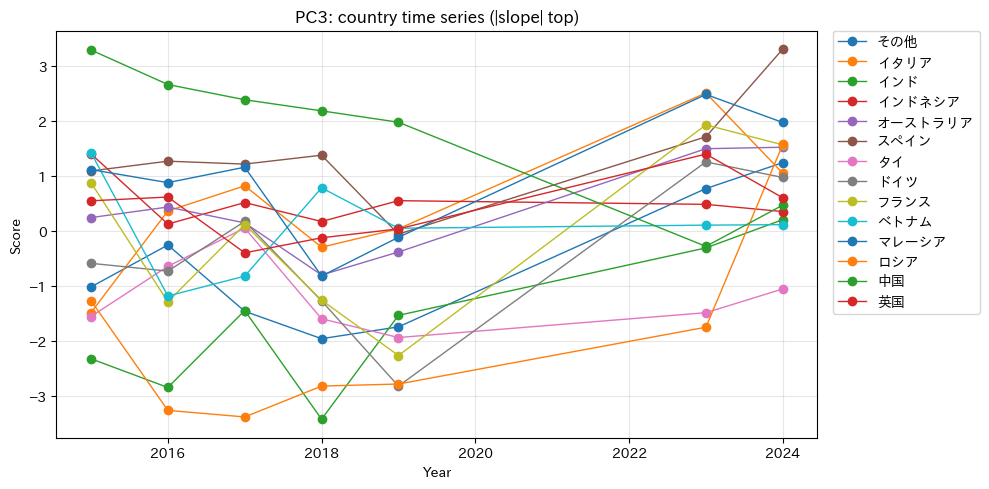

In [ ]:
# ============================================
# トレンド指標（傾き）算出
# ============================================
def calc_slope(x_year: np.ndarray, y: np.ndarray) -> float:
    """単回帰の傾き（年あたり変化量）を返す。観測点が2未満ならNaN。"""
    if len(x_year) < 2:
        return np.nan
    # polyfitで傾き推定（xの単位はyear）
    slope, intercept = np.polyfit(x_year, y, 1)
    return float(slope)

rows = []
for country, g in df_ts.groupby("Country/Area"):
    years = g["Year"].values.astype(float)
    for pc in ["PC1", "PC2", "PC3"]:
        y = g[pc].values.astype(float)
        slope = calc_slope(years, y)
        rows.append({"Country/Area": country, "pc": pc, "slope": slope, "n_years": g["Year"].nunique()})

trend_df = pd.DataFrame(rows)

# 観測年数が少ない国を除外したい場合（任意）
MIN_YEARS = 3
trend_df_f = trend_df[trend_df["n_years"] >= MIN_YEARS].copy()

display(trend_df_f.head(10))
print("Countries used (MIN_YEARS>=3):", trend_df_f["Country/Area"].nunique())
# ============================================
# トレンドランキング（PC別）
# ============================================
TOP_N = 10

for pc in ["PC1", "PC2", "PC3"]:
    tmp = trend_df_f[trend_df_f["pc"] == pc].dropna(subset=["slope"]).copy()
    print(f"\n=== {pc} | slope top (+) ===")
    display(tmp.sort_values("slope", ascending=False).head(TOP_N)[["Country/Area", "slope", "n_years"]])
    print(f"=== {pc} | slope bottom (-) ===")
    display(tmp.sort_values("slope", ascending=True).head(TOP_N)[["Country/Area", "slope", "n_years"]])
# ============================================
# 変化タイプ分類（閾値：|slope| >= 1σ）
# ============================================
classified = []
for pc in ["PC1", "PC2", "PC3"]:
    tmp = trend_df_f[trend_df_f["pc"] == pc].dropna(subset=["slope"]).copy()
    sigma = tmp["slope"].std(ddof=0)  # 母標準偏差
    thr = sigma  # 1σ
    tmp["trend_type"] = np.where(tmp["slope"] >= thr, "Up",
                        np.where(tmp["slope"] <= -thr, "Down", "Flat"))
    tmp["threshold"] = thr
    classified.append(tmp)

trend_class_df = pd.concat(classified, axis=0).reset_index(drop=True)

# PC別に件数確認
counts = trend_class_df.groupby(["pc", "trend_type"]).size().unstack(fill_value=0)
display(counts)

# 詳細一覧（必要に応じてフィルタ）
display(trend_class_df.sort_values(["pc", "trend_type", "slope"], ascending=[True, True, False]).head(30))
# ============================================
# 代表国選定（|slope|上位）
# ============================================
TOP_K = 6
selected_by_trend = set()

for pc in ["PC1", "PC2", "PC3"]:
    tmp = trend_df_f[trend_df_f["pc"] == pc].dropna(subset=["slope"]).copy()
    tmp["abs_slope"] = tmp["slope"].abs()
    selected_by_trend.update(tmp.nlargest(TOP_K, "abs_slope")["Country/Area"].tolist())

selected_by_trend = sorted(selected_by_trend)
print("Selected countries (by |slope| top):", len(selected_by_trend))
selected_by_trend[:20], "..."
# ============================================
# 国別×年の推移（PCごと、|slope|上位国）
# ============================================
df_sel2 = df_ts[df_ts["Country/Area"].isin(selected_by_trend)].copy()

for pc in ["PC1", "PC2", "PC3"]:
    plt.figure(figsize=(10, 5))
    for c in selected_by_trend:
        tmp = df_sel2[df_sel2["Country/Area"] == c]
        if tmp.empty:
            continue
        plt.plot(tmp["Year"], tmp[pc], marker="o", linewidth=1, label=c)

    plt.title(f"{pc}: country time series (|slope| top)")
    plt.xlabel("Year")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()


##### ■PC1（日本文化・体験志向）のトレンド特性

PC1 のトレンドを見ると、**明確な上昇・下降を示す国は限定的**であり、多くの国は「Flat（横ばい）」に分類されている。

一方で、  
- 中国、マレーシア、インドなどでは正の傾きが確認され、日本文化・体験志向が徐々に強まっている可能性が示唆される。
- 英国、インドネシア、ロシア、タイなどでは負の傾きが大きく、相対的に PC1 のスコアが低下している傾向が観測される。

この結果は、PC1 が全体として安定的な基調軸である一方、**一部の国では行動志向の質的変化が進行している可能性**を示している。

##### ■PC2（アクティブ志向 vs 和の寛ぎ・滞在志向）のトレンド特性

PC2 においては、ほとんどの国が「Up」に分類されており、全体として **正の方向へのトレンドが卓越している**。

特に、中国、スペイン、ベトナム、ドイツ、米国などでは比較的大きな正の傾きが確認され、アクティブな行動様式や都市型の消費行動が時間とともに強まっている可能性が示唆される。

一方で、明確な「Down」に分類される国はほぼ見られず、PC2 は市場全体に共通する行動スタイルの変化を捉える軸として機能していることがうかがえる。

##### ■PC3（自然・地方志向 vs 都市型娯楽志向）のトレンド特性

PC3 のトレンドは、PC1・PC2 と比べて **国ごとの差異が大きい**。

ロシア、インド、イタリア、フランスなどでは正の傾きが確認され、自然・地方志向側へのシフトが進んでいる可能性が示唆される。

一方で、中国、台湾、香港などでは負の傾きが観測されており、都市型娯楽志向への相対的な集中、あるいは地方志向の弱まりが示唆される。

この結果は、PC3 が**訪日旅行における行動空間の選択（都市か、自然・地方か）**という点で、市場間の分化を捉える主成分であることを示している。

##### ■トレンド分類の全体像と示唆

トレンドタイプ別に整理すると、

- PC1：多くの国が横ばいであり、基調的な行動志向としての安定性が高い。
- PC2：上昇傾向が多数派であり、行動スタイルの共通的な変化が進行している。
- PC3：上昇・横ばい・下降が混在しており、市場ごとの差別化が顕在化している。

### 4. 市場ポジションの移動 ― 主成分平面上で見る市場構造の変化 ―

主成分同士の組み合わせ（PC1×PC2、PC1×PC3）に着目し、各国市場が主成分平面上でどのように位置を変えてきたかを確認する。

初期年と最新年の主成分スコアを比較し、市場ポジションの移動方向および移動距離を可視化・整理する。

#### 解釈の観点
この分析により、市場が単に「同じ象限にとどまっているか」ではなく、**どの方向へ移動しているか**を把握することができる。

たとえば、文化・体験志向を強めながら都市型に集中する市場、文化志向を維持しつつ自然・地方志向へ移行する市場など、回復や成長の質的な違いが明確になる。

市場ポジションの移動は、インバウンド市場が固定的な構造ではなく、時間とともに性格を変える動的な存在であることを示しており、施策設計や重点市場選定において重要な示唆を与える。

,Country/Area,PC1_start,PC2_start,PC3_start,PC1_end,PC2_end,PC3_end,d_PC1_PC2,d_PC1_PC3
0,その他,2.279857,-1.248517,-1.010902,2.395699,1.222973,1.248975,2.474203,2.262844
1,イタリア,2.359315,-1.718710,-1.477559,1.706881,-0.780906,1.056847,1.142430,2.617037
2,インド,-3.530025,1.134557,-2.316977,-1.088728,3.114453,0.212442,3.143234,3.515379
3,インドネシア,-0.979521,0.183243,1.408057,-1.989437,3.560467,0.359409,3.524993,1.455882
4,オーストラリア,2.050697,0.076871,0.250027,2.714712,2.698263,1.528758,2.704184,1.440857
5,カナダ,2.550849,-0.601430,0.374175,1.797979,0.821770,1.496513,1.610066,1.351464
6,シンガポール,-2.092568,-0.382159,1.530692,-1.436590,1.198695,0.935078,1.711552,0.886038
7,スペイン,4.129360,-2.725415,1.098333,2.512438,0.493225,3.314043,3.601955,2.742956
8,タイ,-0.208294,-0.051731,-1.548687,-2.337545,0.891792,-1.047452,2.328937,2.187452
9,ドイツ,2.356164,-1.841810,-0.581504,2.900987,0.990673,0.979076,2.884405,1.652949


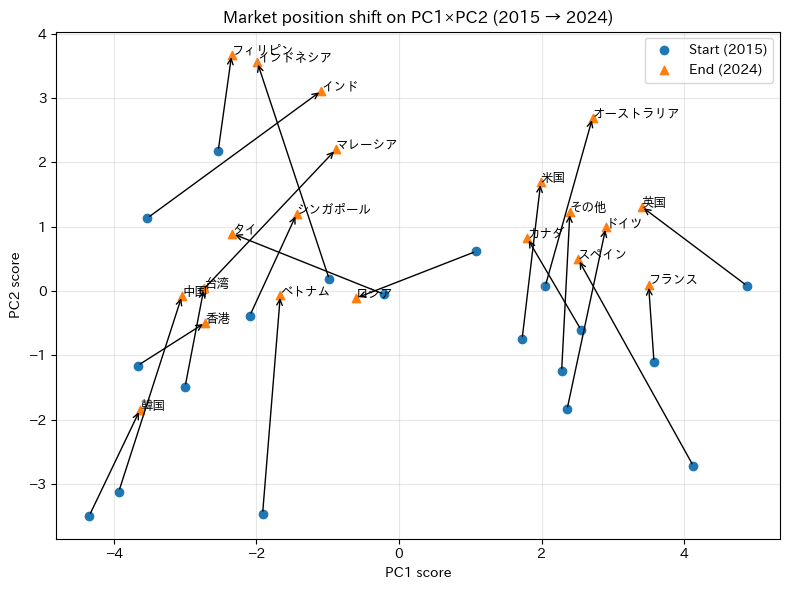

,Country/Area,PC1_start,PC2_start,PC1_end,PC2_end,d_PC1_PC2
7,スペイン,4.129360,-2.725415,2.512438,0.493225,3.601955
3,インドネシア,-0.979521,0.183243,-1.989437,3.560467,3.524993
12,ベトナム,-1.914255,-3.465948,-1.665562,-0.066330,3.408702
15,中国,-3.930921,-3.119116,-3.044145,-0.071059,3.174433
2,インド,-3.530025,1.134557,-1.088728,3.114453,3.143234
9,ドイツ,2.356164,-1.841810,2.900987,0.990673,2.884405
13,マレーシア,-2.747004,0.020502,-0.885092,2.202222,2.868209
4,オーストラリア,2.050697,0.076871,2.714712,2.698263,2.704184
0,その他,2.279857,-1.248517,2.395699,1.222973,2.474203
17,米国,1.725172,-0.751738,1.986913,1.688489,2.454224


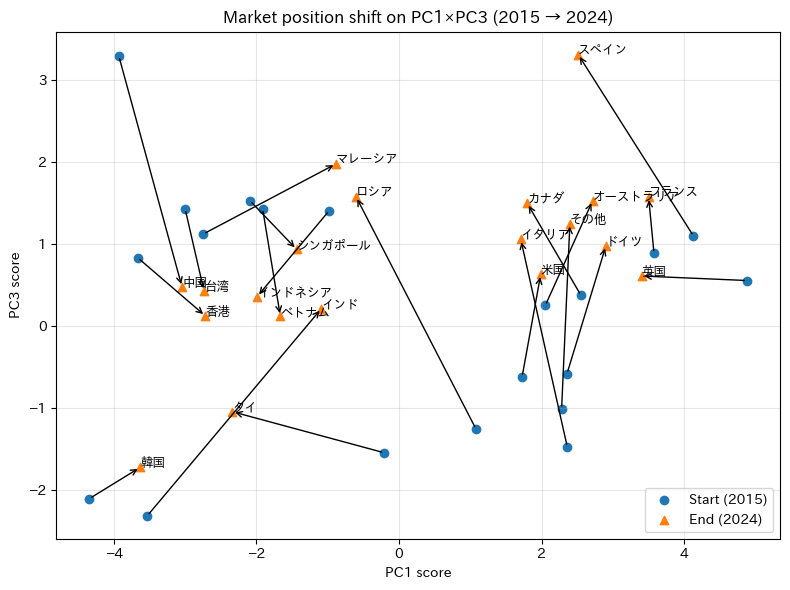

,Country/Area,PC1_start,PC3_start,PC1_end,PC3_end,d_PC1_PC3
2,インド,-3.530025,-2.316977,-1.088728,0.212442,3.515379
14,ロシア,1.079942,-1.260880,-0.604327,1.579208,3.301949
15,中国,-3.930921,3.296881,-3.044145,0.476703,2.956311
7,スペイン,4.129360,1.098333,2.512438,3.314043,2.742956
1,イタリア,2.359315,-1.477559,1.706881,1.056847,2.617037
0,その他,2.279857,-1.010902,2.395699,1.248975,2.262844
8,タイ,-0.208294,-1.548687,-2.337545,-1.047452,2.187452
13,マレーシア,-2.747004,1.122538,-0.885092,1.978974,2.049439
9,ドイツ,2.356164,-0.581504,2.900987,0.979076,1.652949
18,英国,4.881368,0.554789,3.400254,0.609812,1.482136


,quad_start,quad_end,count
1,"Q2 (PC1-, PC3+)","Q2 (PC1-, PC3+)",8
0,"Q1 (PC1+, PC3+)","Q1 (PC1+, PC3+)",5
4,"Q4 (PC1+, PC3-)","Q1 (PC1+, PC3+)",4
3,"Q3 (PC1-, PC3-)","Q3 (PC1-, PC3-)",2
2,"Q3 (PC1-, PC3-)","Q2 (PC1-, PC3+)",1
5,"Q4 (PC1+, PC3-)","Q2 (PC1-, PC3+)",1


Moved quadrant (count): 6 / 21


In [ ]:
# ============================================
# 初期年→最新年の座標作成
# ============================================
first_year = df_ts["Year"].min()
latest_year = df_ts["Year"].max()

df_first = df_ts[df_ts["Year"] == first_year].set_index("Country/Area")[["PC1", "PC2", "PC3"]]
df_last  = df_ts[df_ts["Year"] == latest_year].set_index("Country/Area")[["PC1", "PC2", "PC3"]]

common_countries = sorted(set(df_first.index) & set(df_last.index))

pos_df = pd.DataFrame({
    "Country/Area": common_countries,
    "PC1_start": df_first.loc[common_countries, "PC1"].values,
    "PC2_start": df_first.loc[common_countries, "PC2"].values,
    "PC3_start": df_first.loc[common_countries, "PC3"].values,
    "PC1_end":   df_last.loc[common_countries, "PC1"].values,
    "PC2_end":   df_last.loc[common_countries, "PC2"].values,
    "PC3_end":   df_last.loc[common_countries, "PC3"].values,
})

# 移動距離（2平面で使うが、全体感としても有用）
pos_df["d_PC1_PC2"] = np.sqrt((pos_df["PC1_end"]-pos_df["PC1_start"])**2 + (pos_df["PC2_end"]-pos_df["PC2_start"])**2)
pos_df["d_PC1_PC3"] = np.sqrt((pos_df["PC1_end"]-pos_df["PC1_start"])**2 + (pos_df["PC3_end"]-pos_df["PC3_start"])**2)

display(pos_df.head(10))
# ============================================
# PC1×PC2 平面：移動矢印（上位のみ）
# ============================================
TOP_N = 20  # 表示数（必要に応じて調整）
plot_df = pos_df.sort_values("d_PC1_PC2", ascending=False).head(TOP_N).copy()

plt.figure(figsize=(8, 6))

# 始点・終点
plt.scatter(plot_df["PC1_start"], plot_df["PC2_start"], marker="o", label=f"Start ({first_year})")
plt.scatter(plot_df["PC1_end"], plot_df["PC2_end"], marker="^", label=f"End ({latest_year})")

# 矢印
for _, r in plot_df.iterrows():
    plt.annotate(
        "", 
        xy=(r["PC1_end"], r["PC2_end"]), 
        xytext=(r["PC1_start"], r["PC2_start"]),
        arrowprops=dict(arrowstyle="->", linewidth=1)
    )
    plt.text(r["PC1_end"], r["PC2_end"], r["Country/Area"], fontsize=9)

plt.title(f"Market position shift on PC1×PC2 ({first_year} → {latest_year})")
plt.xlabel("PC1 score")
plt.ylabel("PC2 score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

display(plot_df[["Country/Area", "PC1_start", "PC2_start", "PC1_end", "PC2_end", "d_PC1_PC2"]])
# ============================================
# PC1×PC3 平面：移動矢印（上位のみ）
# ============================================
TOP_N = 20
plot_df = pos_df.sort_values("d_PC1_PC3", ascending=False).head(TOP_N).copy()

plt.figure(figsize=(8, 6))

plt.scatter(plot_df["PC1_start"], plot_df["PC3_start"], marker="o", label=f"Start ({first_year})")
plt.scatter(plot_df["PC1_end"], plot_df["PC3_end"], marker="^", label=f"End ({latest_year})")

for _, r in plot_df.iterrows():
    plt.annotate(
        "", 
        xy=(r["PC1_end"], r["PC3_end"]), 
        xytext=(r["PC1_start"], r["PC3_start"]),
        arrowprops=dict(arrowstyle="->", linewidth=1)
    )
    plt.text(r["PC1_end"], r["PC3_end"], r["Country/Area"], fontsize=9)

plt.title(f"Market position shift on PC1×PC3 ({first_year} → {latest_year})")
plt.xlabel("PC1 score")
plt.ylabel("PC3 score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

display(plot_df[["Country/Area", "PC1_start", "PC3_start", "PC1_end", "PC3_end", "d_PC1_PC3"]])
# ============================================
# 象限移動の集計（PC1×PC3）
# ============================================
def quadrant(x, y):
    # x=PC1, y=PC3
    if x >= 0 and y >= 0:
        return "Q1 (PC1+, PC3+)"
    if x < 0 and y >= 0:
        return "Q2 (PC1-, PC3+)"
    if x < 0 and y < 0:
        return "Q3 (PC1-, PC3-)"
    return "Q4 (PC1+, PC3-)"

q_df = pos_df.copy()
q_df["quad_start"] = q_df.apply(lambda r: quadrant(r["PC1_start"], r["PC3_start"]), axis=1)
q_df["quad_end"]   = q_df.apply(lambda r: quadrant(r["PC1_end"], r["PC3_end"]), axis=1)
q_df["moved"] = q_df["quad_start"] != q_df["quad_end"]

transition = (
    q_df.groupby(["quad_start", "quad_end"]).size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
)

display(transition.head(20))
print("Moved quadrant (count):", q_df["moved"].sum(), "/", len(q_df))


##### ■PC1×PC2 平面における市場ポジションの変化（文化・体験志向 × 行動スタイル）

PC1×PC2 平面では、多くの国で **一定規模のポジション移動**が確認されており、特に PC2 方向（行動スタイル軸）での変化が顕著である。

スペイン、インドネシア、ベトナム、中国、インドなどでは、PC1×PC2 平面上での移動距離（d_PC1_PC2）が大きく、行動様式や旅行スタイルに関する構造的な変化が進行している可能性が示唆される。

一方で、PC1 の符号自体が大きく反転する国は限定的であり、文化・体験志向の相対的位置づけは一定程度維持されたまま、**その上で行動スタイルが変化している市場が多い**ことが読み取れる。

これは、訪日旅行において「何に関心を持つか（PC1）」よりも「どのように行動するか（PC2）」の側面で変化が生じやすいことを示唆している。

##### ■PC1×PC3 平面における市場ポジションの変化（文化・体験志向 × 行動空間）

PC1×PC3 平面では、PC1×PC2 と比べて**移動の方向性が国ごとに大きく分かれる**傾向が確認される。

インド、ロシア、スペイン、イタリアなどでは、PC3 方向の変化量が大きく、自然・地方志向と都市型娯楽志向の間で行動空間の重心が移動している可能性が示唆される。

一方、中国、台湾、香港などでは、PC3 が低下方向に推移しており、都市型行動への相対的な集中、あるいは地方志向の弱まりを反映している可能性がある。

この結果から、PC3 は、**訪日旅行の舞台となる空間の選択に関して、市場間の分化を捉える軸**として機能していることが示唆される。

##### ■四象限の移動状況と市場構造の安定性

PC1×PC3 平面を四象限に分けて整理すると、21 か国中 6 か国が期間中に象限を移動している。

一方で、多くの国は同一象限内にとどまっており、市場構造全体としては一定の安定性を保ちつつ、一部の市場でのみ相対的に大きな構造変化が生じていることが確認できる。

特に、  
- PC1・PC3 ともに正の領域に留まる市場  
- PC1 が負で PC3 が正の市場  

といったグループは一定数維持されており、市場の大枠の類型は短期間で大きく崩れていないことが示唆される。

##### ■主成分平面から見た市場動態の整理

以上の分析から、以下の点が示唆される。

- 多くの市場では、主成分平面上で一定のポジション移動が観測されるものの、主成分構造そのものが大きく崩れるほどの変化は限定的である。
- PC2 および PC3 方向での移動が相対的に大きく、行動スタイルや行動空間の変化が市場差として顕在化している。
- PC1 は基調的な軸として比較的安定しており、その上で PC2・PC3 が市場の動態を補足的に捉えている。

### 6. 結論とインサイト ― 主成分スコアの時系列分析から見たインバウンド市場の動態 ―

本分析では、031_Behavior_PCA.ipynb において抽出・解釈した 3 つの主成分（PC1〜PC3）を用い、各国市場の主成分スコアの時系列推移および市場ポジションの変化を分析した。
その結果、訪日インバウンド市場は「静的な国別特性」ではなく、**主成分ごとに異なる時間的ダイナミクスを持つ構造的市場**であることが確認された。

##### 1. PC1（文化・体験志向）は基調的かつ比較的安定した軸である

PC1 はスコア分布の変動幅が最も大きく、国別水準の差異も明確である一方、トレンド分析では多くの国が「横ばい」に分類された。

このことから、PC1 は、**訪日旅行における基調的な関心軸（文化・体験への関心の強さ）**として市場を長期的に特徴づける役割を担っており、短期的な変動よりも「市場の性格」を捉える軸として有効であることが示唆される。

一方で、中国・マレーシア・インドなど一部の国では、PC1 が上昇傾向を示しており、基調軸であっても市場によっては質的変化が進行している可能性が示唆される。

##### 2. PC2（行動スタイル）は多くの市場で共通して変化している

PC2 のトレンド分析では、大半の国が正の傾きを示し、「Up」に分類された。
これは、**訪日旅行における行動様式（アクティブ性・都市型行動など）が、国を超えて共通の方向に変化している可能性**を示唆している。

PC2 は国別差よりも「時代的変化」「市場全体の行動様式の変容」を捉える軸として機能しており、インバウンド市場全体の行動スタイルの変化を読み解くうえで重要な補助軸であると位置づけられる。

##### 3. PC3（行動空間）は市場間の分化を捉える軸である

PC3 については、上昇・横ばい・下降が国ごとに混在しており、トレンドの方向性に明確なばらつきが見られた。
これは、**訪日旅行の主な行動空間（都市型か、自然・地方型か）が、市場ごとに異なる方向へ分化している可能性**を示している。

特に、  
- 一部の国では自然・地方志向側へのシフト  
- 別の国では都市型志向への集中  

が同時並行で進行しており、PC3 は市場間の差別化やセグメンテーションを考えるうえで重要な視点を提供する主成分であると示唆される。

##### 4. 市場ポジションの移動が示す構造的示唆

主成分平面（PC1×PC2、PC1×PC3）上での市場ポジション分析からは、多くの国で一定の移動が観測されたものの、**象限そのものが大きく入れ替わる市場は限定的**であった。

この結果は、  
- 主成分構造（市場の大枠の類型）は比較的安定している一方で  
- その内部で行動スタイルや行動空間が調整・変化している  

という二層構造の市場変化を示唆している。

##### 総括的インサイト

以上の分析を踏まえると、訪日インバウンド市場は、

-  **PC1（文化・体験志向）** を基調軸として市場の性格を把握しつつ  
-  **PC2（行動スタイル）** によって共通的な時代変化を捉え  
-  **PC3（行動空間）** によって市場間の分化を読み解く  

という多軸的な視点で理解することが有効であると考えられる。

本分析の結果は、PC1 を中心軸としながら PC2・PC3 を組み合わせて市場の動態を把握するという分析フレームが、インバウンド市場の構造理解および戦略的検討において実務的に活用可能であることが示唆される。